### <center><h1>Rashinkar_Payal_HW4</h1></center>
<br>
<br>

Name: Payal Rashinkar
<br>
Github Username: PayalRashinkar
<br>
USC ID: 3885-1419-03

## 1. Time Series Classification Part 1: Feature Creation/Extraction

### (a) Download Data

Package imports

In [1]:
import os
import random
import re
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [2]:
Folder = '../data/AReM/'
COLUMN_NAMES = ["# Columns: time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
ORDERED_STATS = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
sniffer = csv.Sniffer()

Get the AReM Data Set

https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+%5C%28AReM%5C%29

### (b) Test and Train Data

In [3]:
def splitting(root_dir):
    train_files = []
    test_files = []
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if 'pdf' not in file:
                file_path = os.path.join(root, file)
                
                if 'bending1' in file_path or 'bending2' in file_path:
                    if 'dataset1.csv' in file_path or 'dataset2.csv' in file_path:
                        test_files.append(file_path)
                    else:
                        train_files.append(file_path)
                else:
                    if 'dataset1.csv' in file_path or 'dataset2.csv' in file_path or 'dataset3.csv' in file_path:
                        test_files.append(file_path)
                    else:
                        train_files.append(file_path)
    
    return train_files, test_files

train, test = splitting(Folder)

### (c) Feature Extraction

#### ii. Extraction

In [4]:
def feature(segments=1):
    end = 6 * segments + 1
    features = []
    for i in range(1, end):
        for stat in ORDERED_STATS:
            features.append(f'{stat}{i}')
    return features

def filename(file):
    parent_directory = os.path.dirname(file)
    filename_components = parent_directory.split("/")
    return filename_components[-1]

def delimiter(file):
    f = open(file)
    return sniffer.sniff(f.read()).delimiter

def process_data(features, columns, files, segments=1, standard=False):
    instances = []
    labels = []
    for file in files:
        labels.append(filename(file))
        delimit = delimiter(file)

        if delimit == ",":
            df = pd.read_csv(file, skiprows=5, header=None, on_bad_lines='skip')
        elif delimit == "\\s+":
            df = pd.read_csv(file, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
        else:
            df = pd.read_csv(file, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
        df.columns = COLUMN_NAMES

        seg_length = int(df.shape[0] / segments)
        description = []
        for i in range(segments):
            start = i * seg_length
            end = min((i + 1) * seg_length, df.shape[0])
            cur_seg = df[start:end]
            time_col = "# Columns: time"
            cur_describe = cur_seg.describe().drop('count').drop(columns=time_col).T
            description.append(cur_describe.values.flatten())

        instances.append(np.concatenate(description))
    
    feature_table = pd.DataFrame(instances)
    feature_table.columns = feature(segments)
    feature_table = feature_table.loc[:, features]
    feature_table['label'] = pd.Series(labels)
    
    return feature_table

def get_heading():
    features = []
    for i in range(1, 7):
        for stat in ORDERED_STATS:
            features.append(f'{stat}{i}')
    return features

feat = get_heading()
train_col = process_data(feat, COLUMN_NAMES, train)
test_col = process_data(feat, COLUMN_NAMES, test)
train_col

min1      max1  mean1  median1   std1  1st_quartile1  3rd_quartile1  \
0   43.969125  1.618364  36.25   43.310  44.50          44.67          48.00   
1   43.454958  1.386098  37.00   42.500  43.25          45.00          48.00   
2   42.179812  3.670666  33.00   39.150  43.50          45.00          47.75   
3   41.678063  2.243490  33.00   41.330  41.75          42.75          45.75   
4   43.954500  1.558835  35.00   43.000  44.33          45.00          47.40   
..        ...       ...    ...      ...    ...            ...            ...   
64  35.752354  4.614802  18.50   33.000  36.00          39.33          44.25   
65  37.177042  3.581301  24.25   34.500  36.25          40.25          45.00   
66  36.248768  3.824632  23.33   33.415  36.75          39.25          43.50   
67  36.957458  3.434863  26.25   34.500  36.29          40.25          44.25   
68  37.142359  3.762442  27.75   34.000  36.33          40.50          44.67   

        min2      max2  mean2  ...  1st_quartile5  3rd_quartile5      min6  \
0   0.413125  0.263111    0.0  ...        23.7500          30.75  0.555312   
1   0.378083  0.315566    0.0  ...        24.0000          33.50  0.679646   
2   0.696042  0.630860    0.0  ...        36.3300          38.67  0.613521   
3   0.535979  0.405469    0.0  ...        31.2500          37.50  0.383292   
4   0.426250  0.338690    0.0  ...        36.5000          38.50  0.493292   
..       ...       ...    ...  ...            ...            ...       ...   
64  3.328104  2.140576    0.0  ...        18.0625          24.33  3.069667   
65  2.374208  1.601799    0.0  ...        21.7500          25.50  2.921729   
66  2.737307  2.093999    0.0  ...        21.0000          27.00  3.532463   
67  2.420083  1.724901    0.0  ...        18.2500          22.25  2.934625   
68  2.422150  1.643498    0.0  ...        18.7500          23.00  2.825720   

        max6  mean6  median6   std6  1st_quartile6  3rd_quartile6     label  
0   0.487826    0.0   0.0000  0.490          0.830           2.96  bending1  
1   0.622534    0.0   0.4300  0.500          0.870           5.26  bending1  
2   0.524317    0.0   0.0000  0.500          1.000           2.18  bending1  
3   0.389164    0.0   0.0000  0.430          0.500           1.79  bending1  
4   0.513506    0.0   0.0000  0.430          0.940           1.79  bending1  
..       ...    ...      ...    ...            ...            ...       ...  
64  1.748326    0.0   1.7975  2.770          4.060           9.39   cycling  
65  1.852600    0.0   1.5000  2.500          3.900           9.34   cycling  
66  1.965267    0.0   2.1700  3.110          4.625          11.15   cycling  
67  1.631380    0.0   1.6600  2.525          4.030           8.34   cycling  
68  1.637312    0.0   1.5900  2.590          3.740           8.75   cycling  

[69 rows x 43 columns]

#### iii. Standard Deviation

In [5]:
def resample_data(data):
    resampled = data.sample(frac=1, replace=True)  # Bootstrap resampling
    return resampled

def calculate_std(data):
    return data.apply(np.std)

def calculate_confidence_interval(data):
    lower_bound = np.percentile(data, 5)
    upper_bound = np.percentile(data, 95)
    return (lower_bound, upper_bound)

data = train_col.iloc[:, :-1]
num_samples = 1000

ans = []
for sample in range(num_samples):
    resampled = resample_data(data)
    temp = calculate_std(resampled)
    ans.append(temp)

ans_df = pd.DataFrame(ans, columns=data.columns)

interval = ans_df.apply(calculate_confidence_interval, axis=0)
interval = interval.round(2)
interval = interval.transpose()
interval.columns = ['Lower Bound Confidence', 'Upper Bound Confidence']

#### iv. Select Features

In [6]:
train_df = pd.DataFrame(train_col)

train_df['label'] = train_df['label'].apply(lambda x: 1 if x in ['bending1', 'bending2'] else 0)

for stat in ORDERED_STATS:
    for i in range(1, 7):
        bending_data = train_df.loc[train_df['label'] == 1, stat + str(i)]
        not_bending_data = train_df.loc[train_df['label'] == 0, stat + str(i)]

        #sns.distplot(bending_data, label='Bending', kde=True, hist=False)
        #sns.distplot(not_bending_data, label='Not Bending', kde=True, hist=False)
        #plt.show()

# Home Work4 Part 2

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots


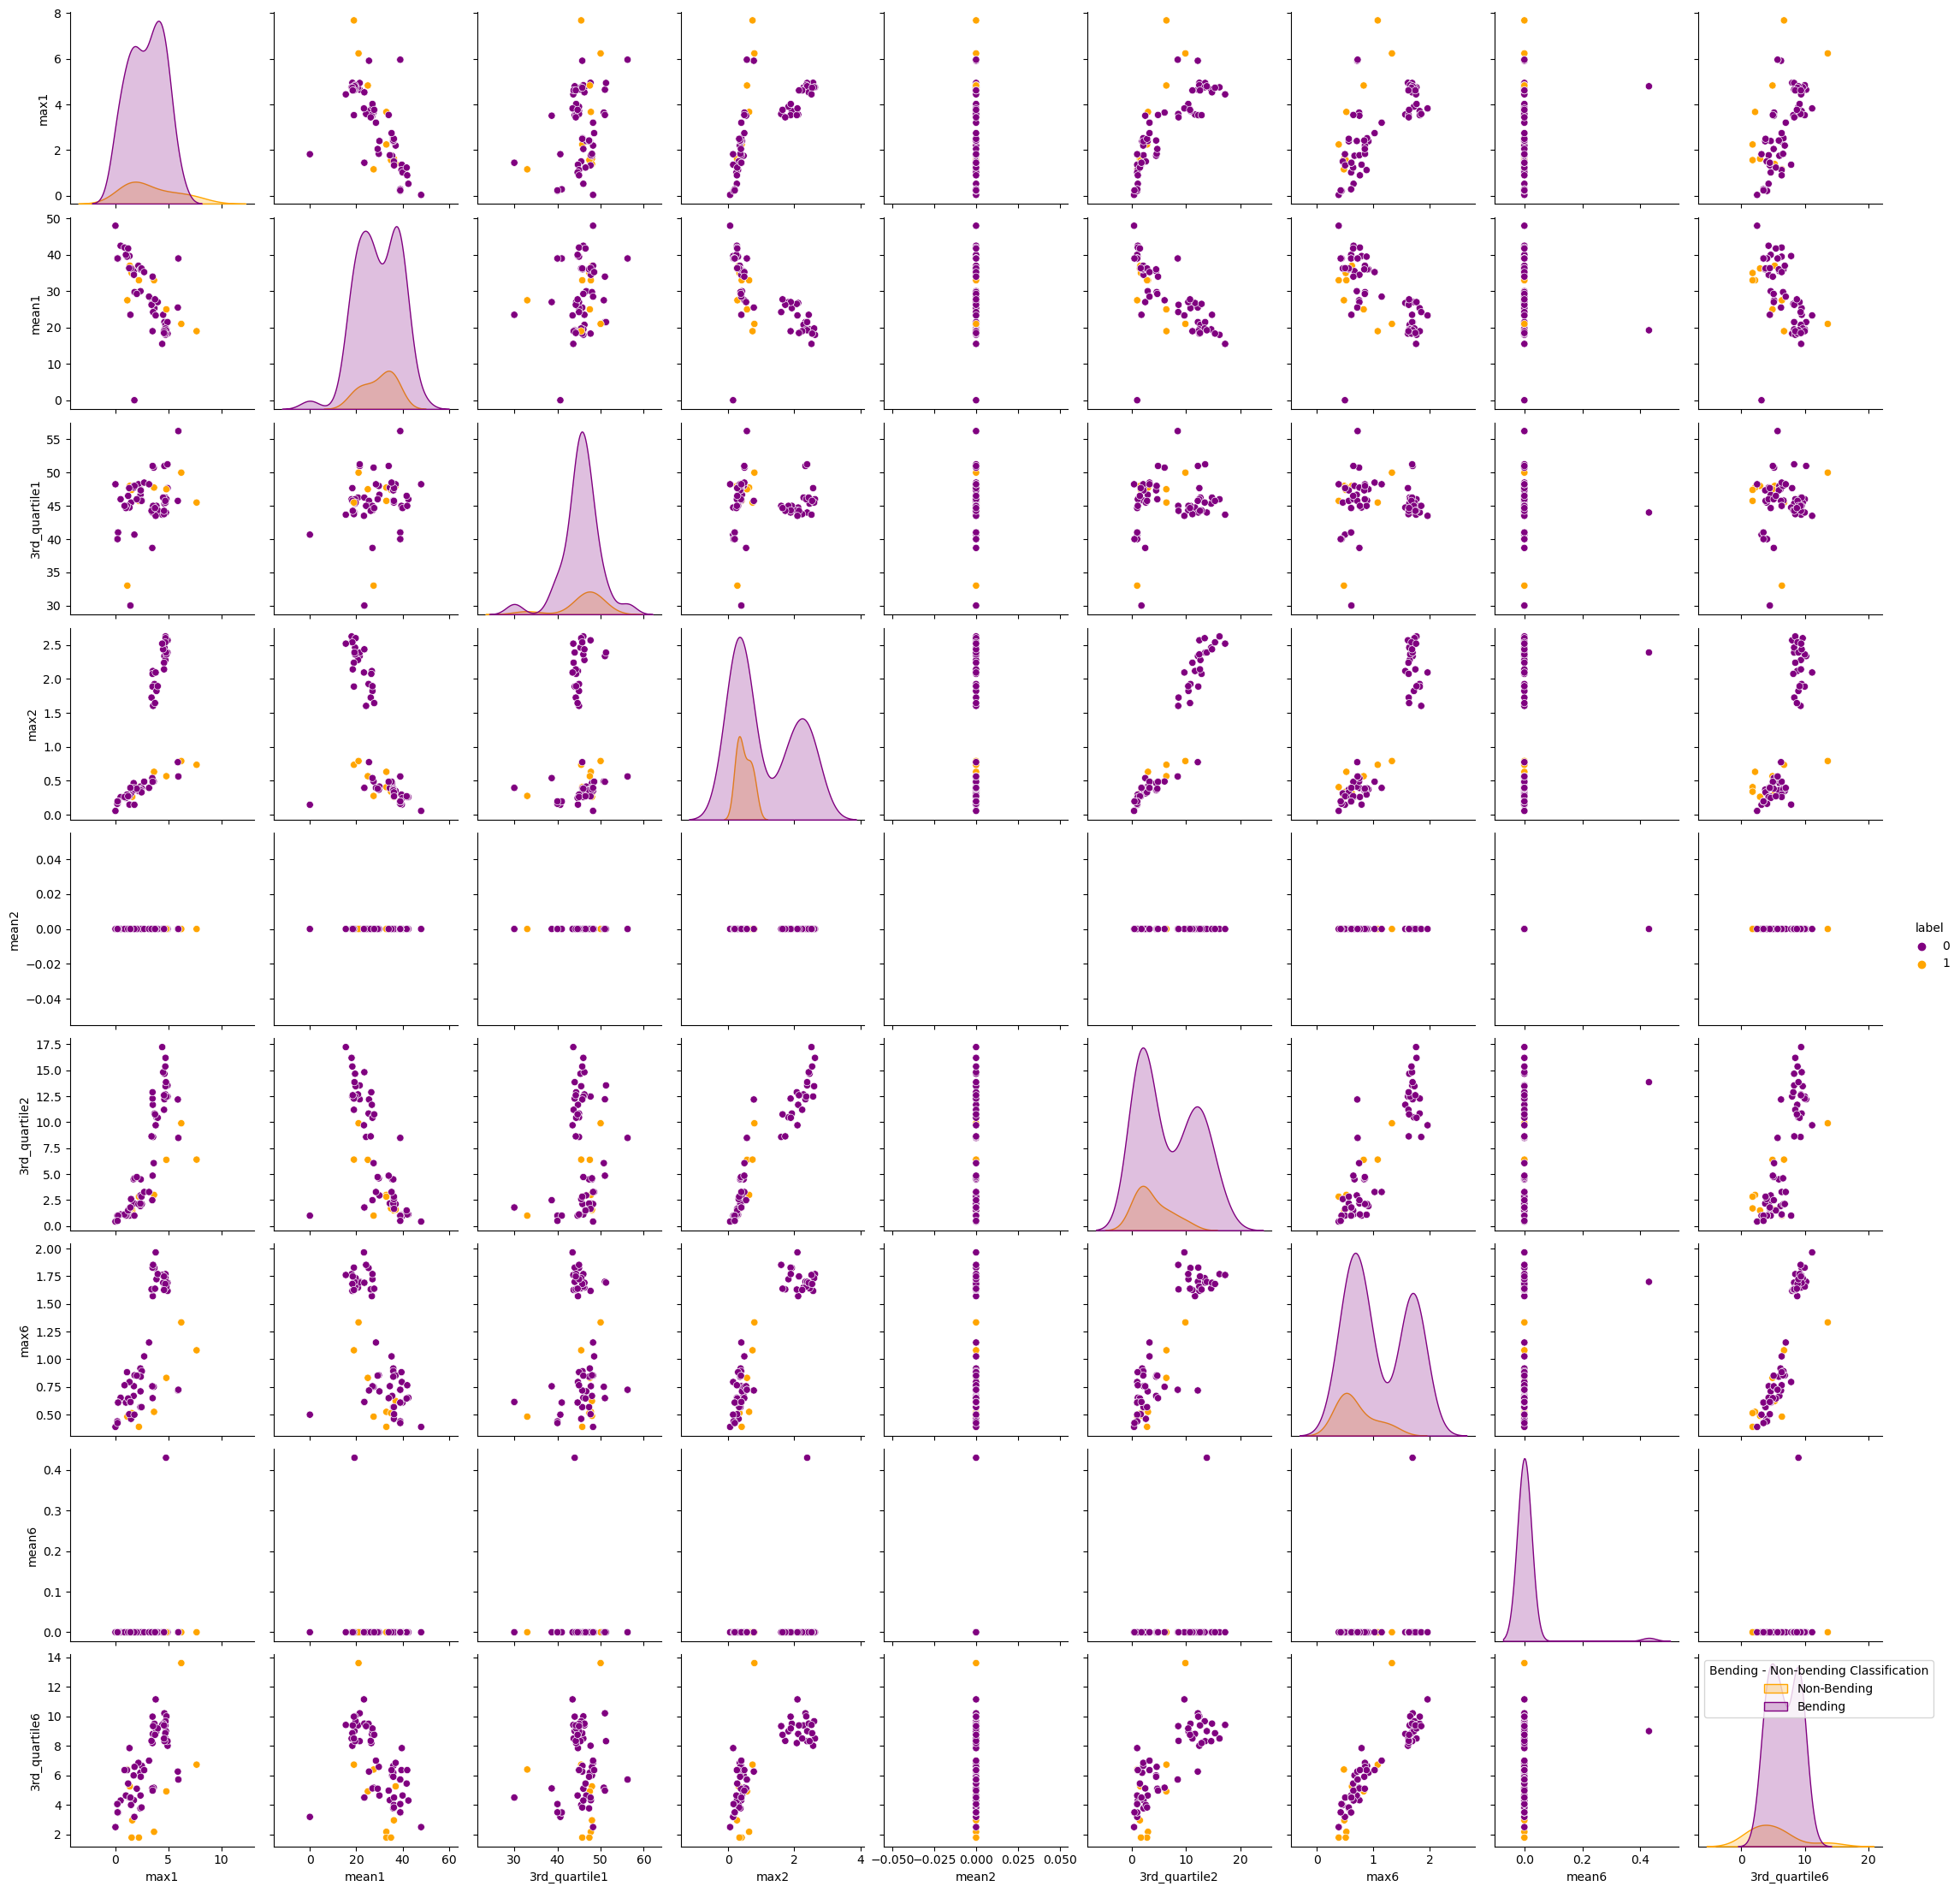

In [7]:
def generate_columns(indexes, properties):
    columns = [prop + str(index) for index in indexes for prop in properties]
    return columns

def label_data(df, columns):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = 1
    df.loc[temp != 1, 'label'] = 0
    return columns + ['label']

def plot_scatter_plot(df, hue_value):
    sns.pairplot(df, hue=hue_value, palette=['purple', 'orange'])
    plt.legend(title='Bending - Non-bending Classification', loc='upper left', labels=['Non-Bending', 'Bending'])
    plt.show()

relevant_columns = generate_columns([1, 2, 6], ['max', 'mean', '3rd_quartile'])
relevant_columns_labeled = label_data(train_col, relevant_columns)
relevant_df = train_col[relevant_columns_labeled]
plot_scatter_plot(relevant_df, 'label')

#### ii. Splitted Plots

In [8]:
def binary_classify(df):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = 1
    df.loc[temp != 1, 'label'] = 0
    return df

In [9]:
features = []
for i in range(1, 13):
    for stat in ORDERED_STATS:
        col_name = f'{stat}{i}'
        features.append(col_name)

train_col_12 = process_data(features, COLUMN_NAMES, train, segments=2)
test_col_12 = process_data(features, COLUMN_NAMES, test, segments=2)

In [10]:
train_12 = binary_classify(pd.DataFrame(train_col_12))
train_12

min1      max1  mean1  median1   std1  1st_quartile1  3rd_quartile1  \
0   43.486208  1.281976  36.67  42.3300  43.71          44.50          45.00   
1   44.117042  1.359836  39.00  43.5000  45.00          45.00          48.00   
2   43.278875  3.473355  33.75  42.0000  45.00          45.25          47.75   
3   41.621208  3.118644  33.00  39.6525  42.33          44.25          45.75   
4   44.057167  1.556971  36.50  43.2500  44.50          45.00          46.50   
..        ...       ...    ...      ...    ...            ...            ...   
64  35.692167  4.643595  20.00  33.0000  35.50          39.25          44.25   
65  36.954208  3.772836  24.25  34.2500  36.00          40.25          45.00   
66  36.337908  3.655379  27.00  33.6700  36.75          39.00          42.67   
67  36.865417  3.462793  26.25  34.3100  36.25          40.00          43.40   
68  37.132636  3.808255  27.75  34.0000  36.67          40.33          44.00   

        min2      max2  mean2  ...  1st_quartile11  3rd_quartile11     min12  \
0   0.378667  0.284434    0.0  ...         23.5000           26.00  0.585750   
1   0.250042  0.314099    0.0  ...         23.7500           26.00  0.543875   
2   0.673292  0.634285    0.0  ...         33.7500           38.50  0.586083   
3   0.623083  0.489595    0.0  ...         30.5625           36.00  0.347500   
4   0.381042  0.329540    0.0  ...         36.2500           38.25  0.388333   
..       ...       ...    ...  ...             ...             ...       ...   
64  3.324208  2.162230    0.0  ...         18.2500           24.33  2.966917   
65  2.392667  1.523329    0.0  ...         21.6700           24.50  2.838083   
66  2.698494  2.019077    0.0  ...         21.0000           26.67  3.530669   
67  2.387250  1.625296    0.0  ...         18.0000           21.25  2.904458   
68  2.388870  1.671298    0.0  ...         18.7500           23.00  2.727866   

       max12  mean12  median12  std12  1st_quartile12  3rd_quartile12  label  
0   0.487918     0.0    0.4225   0.50          0.8300            2.96      1  
1   0.473445     0.0    0.4300   0.50          0.7100            4.06      1  
2   0.491873     0.0    0.0000   0.47          0.8700            2.18      1  
3   0.363144     0.0    0.0000   0.43          0.5000            1.50      1  
4   0.478528     0.0    0.0000   0.00          0.7100            1.50      1  
..       ...     ...       ...    ...             ...             ...    ...  
64  1.712062     0.0    1.8525   2.59          3.7400            8.81      0  
65  1.890755     0.0    1.3825   2.45          3.8325            9.34      0  
66  1.998170     0.0    2.1700   3.08          4.5150           11.15      0  
67  1.609793     0.0    1.6900   2.57          3.7700            8.34      0  
68  1.588045     0.0    1.5000   2.55          3.7000            7.93      0  

[69 rows x 85 columns]

In [11]:
test_12 = binary_classify(pd.DataFrame(test_col_12))
test_12

min1      max1  mean1  median1    std1  1st_quartile1  3rd_quartile1  \
0   40.946958  1.102963  38.00  40.3100  41.250        42.0000          42.33   
1   42.643292  0.641849  41.75  42.0000  42.500        43.3300          44.25   
2   34.334833  4.772089  22.33  30.4750  35.750        37.7500          42.50   
3   33.762958  5.001292  18.67  30.7500  34.500        37.3125          45.00   
4   33.591625  5.121057  15.00  30.0000  34.250        37.0000          45.33   
5   24.675375  4.856867  12.75  22.2500  24.330        26.7500          51.00   
6   29.071583  1.133954  26.50  28.2500  29.500        30.0000          31.33   
7   46.127875  1.151699  38.50  45.5000  46.500        46.7500          48.00   
8   43.043292  1.874343  35.50  42.5000  43.500        44.5000          45.00   
9   44.447083  1.667042  37.00  44.1875  45.000        45.5000          46.50   
10  42.681292  0.803629  40.50  42.0000  42.585        43.5000          44.00   
11  45.811458  1.421195  37.00  45.0000  45.000        46.5000          50.75   
12  45.409875  0.529789  45.00  45.0000  45.250        45.7500          46.75   
13  27.368417  1.295725  23.50  27.0000  27.000        28.7500          29.75   
14  40.361042  9.125029  24.75  29.5000  48.000        48.0000          48.25   
15  48.001042  0.016137  48.00  48.0000  48.000        48.0000          48.25   
16  36.954208  3.772836  24.25  34.2500  36.000        40.2500          45.00   
17  37.592250  3.127179  29.25  35.2500  37.000        39.7500          44.75   
18  37.740667  3.536378  28.00  35.2500  36.710        40.7500          44.67   

        min2      max2  mean2  ...  1st_quartile11  3rd_quartile11     min12  \
0   0.375667  0.328089   0.00  ...         36.5000           38.25  0.552167   
1   0.355000  0.258298   0.00  ...         33.7500           38.50  0.533583   
2   3.974958  2.340613   0.00  ...         18.5000           26.00  3.400750   
3   4.400833  2.456623   0.43  ...         18.8125           24.25  3.378250   
4   4.573042  2.382139   0.00  ...         18.5000           24.50  3.206833   
5   0.774500  1.085015   0.00  ...         21.7500           26.75  0.936917   
6   0.231208  0.265205   0.00  ...         20.7625           33.00  1.473250   
7   0.424542  0.266714   0.00  ...         12.0000           18.25  0.870042   
8   0.500667  0.297224   0.00  ...         17.0000           21.25  0.874750   
9   0.410458  0.304306   0.00  ...         18.8125           21.25  0.906500   
10  0.365875  0.258041   0.00  ...         18.7500           28.00  0.928792   
11  0.204167  0.445279   0.00  ...         20.7500           22.00  0.987000   
12  0.260750  0.273161   0.00  ...         21.0000           22.00  0.720083   
13  0.308042  0.421739   0.00  ...         10.0000           17.00  0.801083   
14  0.194583  0.467226   0.00  ...          2.5000           10.00  0.524500   
15  0.001792  0.027756   0.00  ...         10.7500           12.00  0.612333   
16  2.392667  1.523329   0.00  ...         21.6700           24.50  2.838083   
17  2.111625  1.574180   0.00  ...         21.5425           24.33  2.746417   
18  2.147167  1.993348   0.00  ...         19.3125           23.75  3.348542   

       max12  mean12  median12  std12  1st_quartile12  3rd_quartile12  label  
0   0.510494     0.0    0.0000  0.430          0.9400            1.92      1  
1   0.575061     0.0    0.0000  0.430          0.8700            3.11      1  
2   1.804246     0.0    2.0600  3.080          4.5000            8.86      0  
3   1.803453     0.0    2.0575  3.110          4.4550            8.96      0  
4   1.710663     0.0    1.9800  2.980          4.2450            8.26      0  
5   0.818833     0.0    0.4700  0.810          1.0975            4.97      1  
6   1.238675     0.0    0.5000  1.220          1.9525            6.76      1  
7   0.678663     0.0    0.4600  0.820          1.1450            3.77      0  
8   0.635470     0.0    0.4700  0.830          1.1700            4.64      0

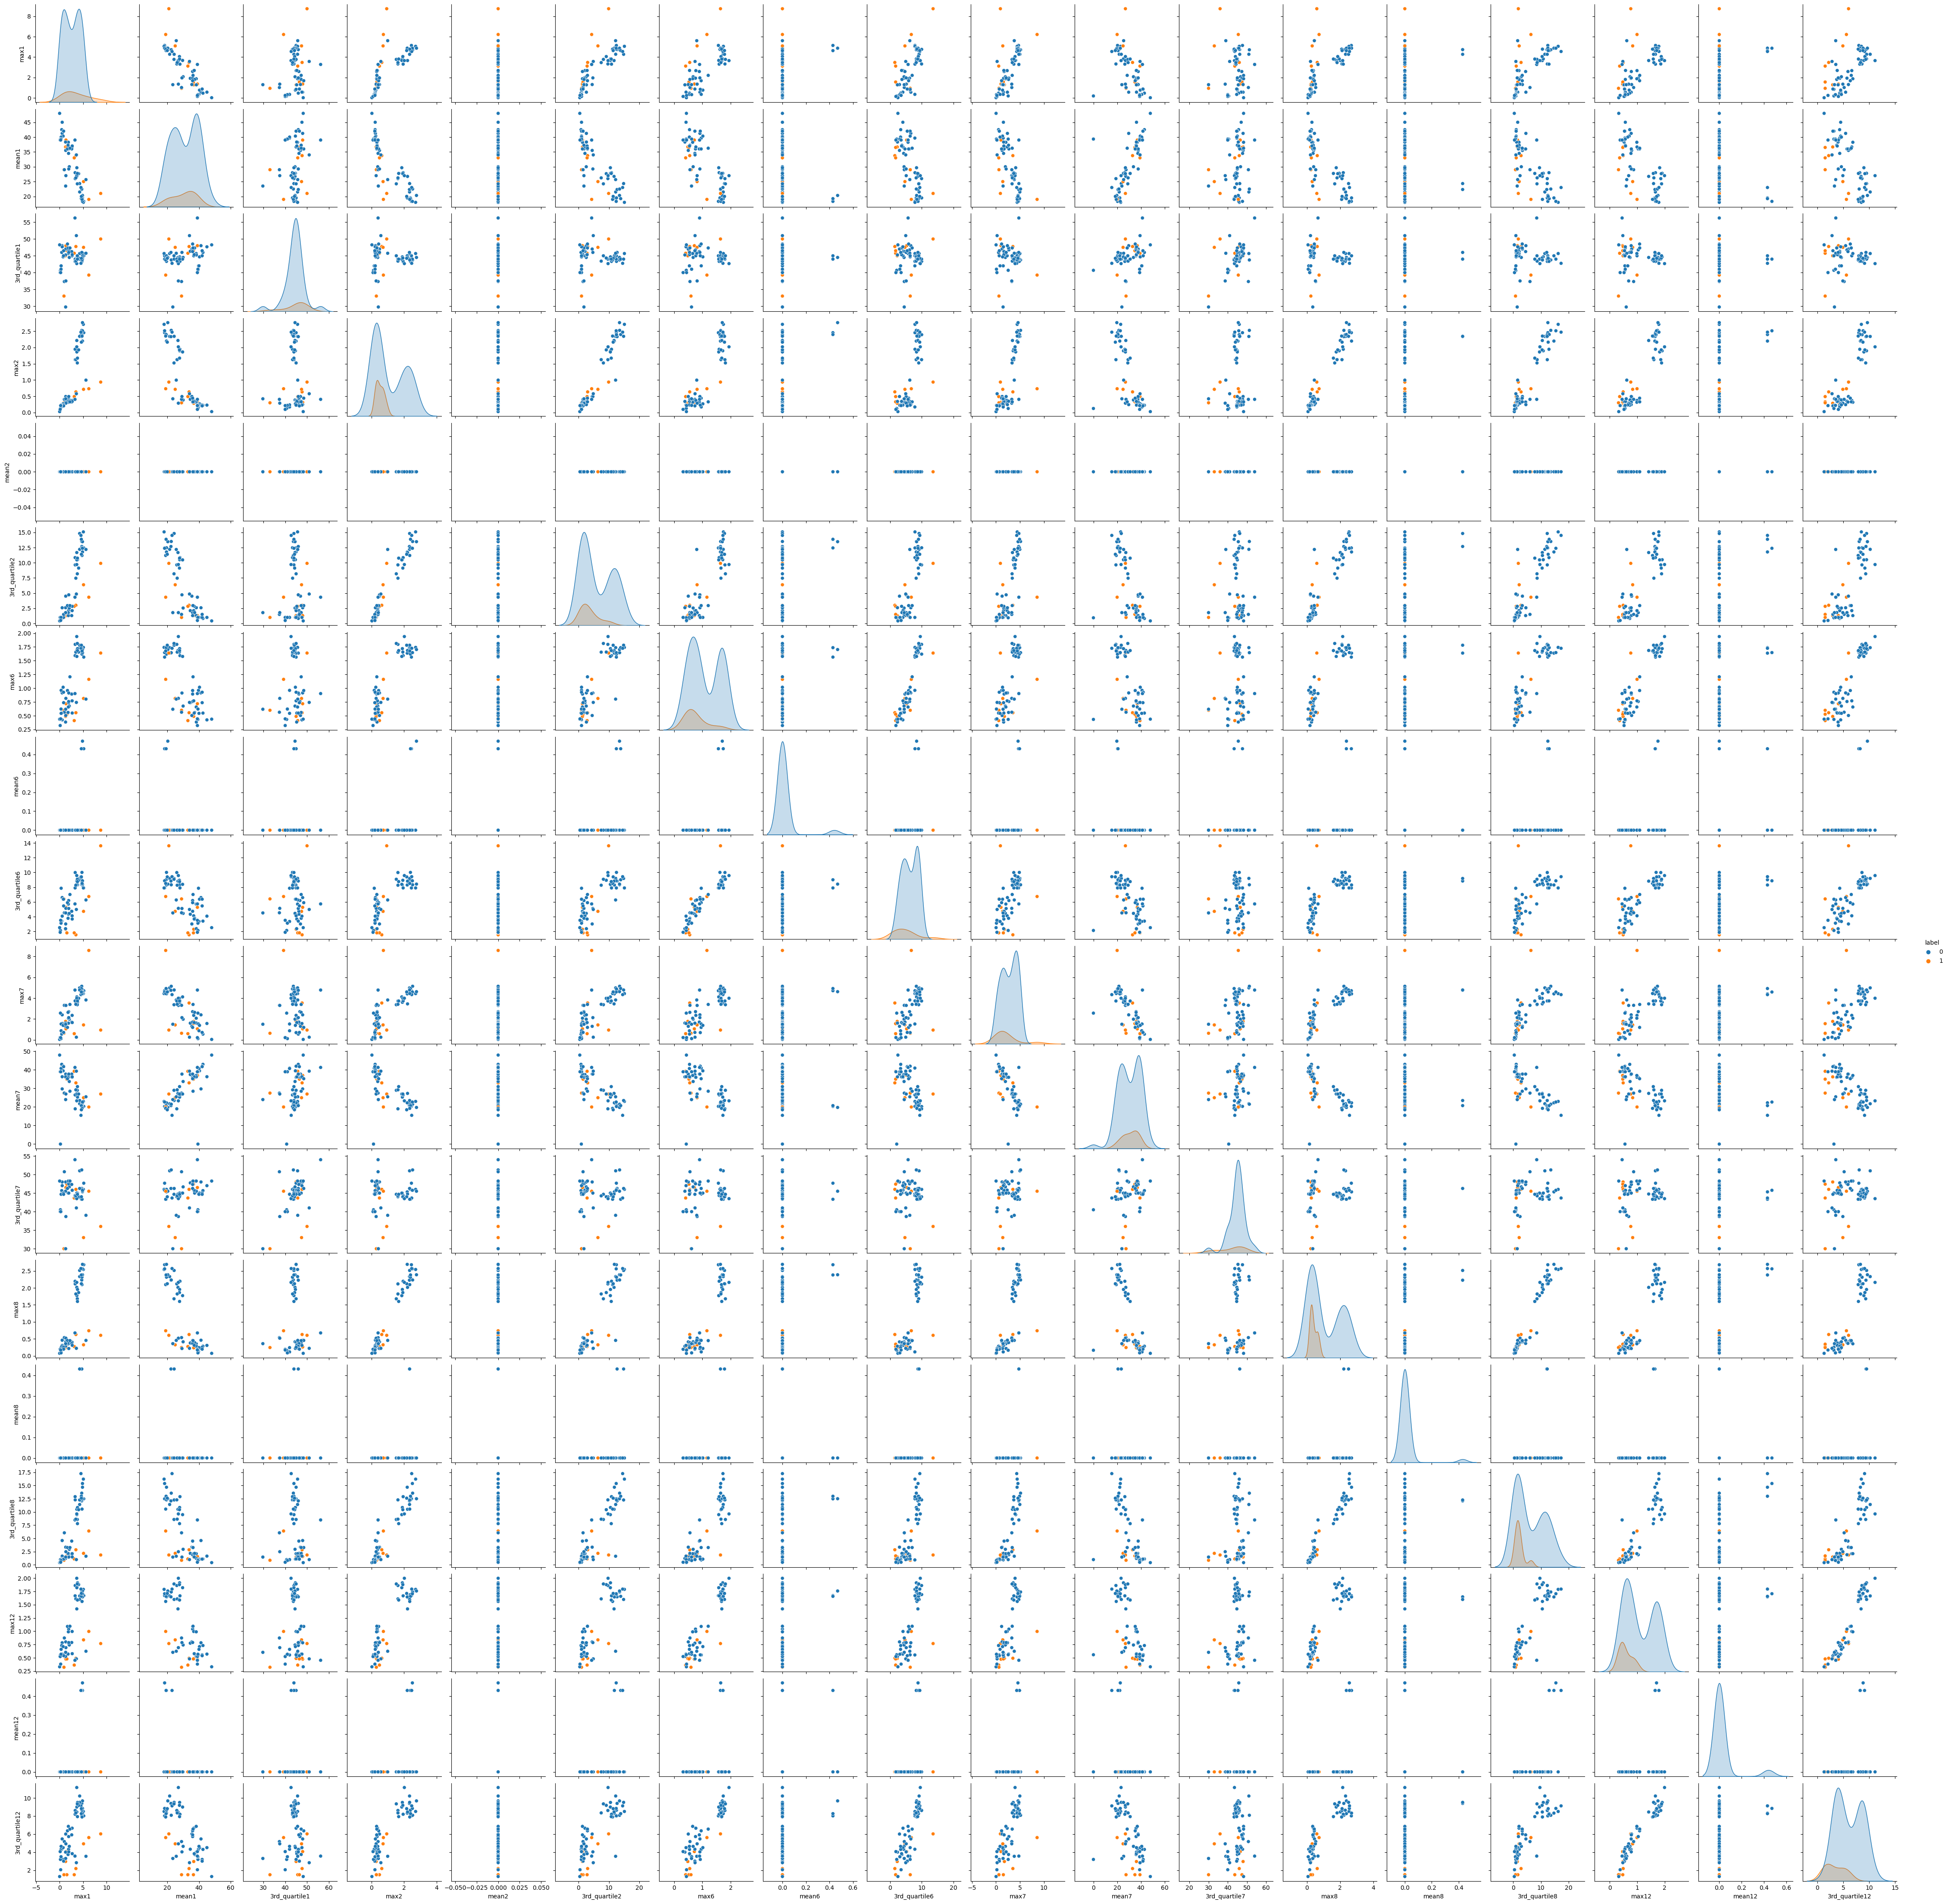

In [12]:
relevant_columns_two = generate_columns([1, 2, 6, 7, 8, 12], ['max', 'mean', '3rd_quartile'])
relevant_columns_labelled_two = label_data(train_col, relevant_columns_two)
relevant_df_two = train_col_12[relevant_columns_labelled_two]
sns.pairplot(relevant_df_two, hue='label')
plt.show()

There is no much difference seen amongst the two of them. The resulting graph seem the same at a glance with negligible variation.

#### iii. Time Series Segments

In [13]:
def generate_features(stats, range_end):
    features = [f'{stat}{i}' for i in range(1, range_end) for stat in stats]
    return features

def oversample_dataset(dataset):
    print('Performing oversampling of dataset...')
    label_0 = dataset.loc[dataset['label'] == "0"].shape[0]
    label_1 = dataset.loc[dataset['label'] == "1"].shape[0]
    minor_count = min(label_0, label_1)
    major_count = max(label_0, label_1)
    
    if label_0 > label_1:
        minor_label = "1"
        major_label = "0"
    else:
        minor_label = "0"
        major_label = "1"
        
    minor_ds = dataset[dataset['label'] == minor_label]
    major_ds = dataset[dataset['label'] == major_label]
    minor_ds = resample(minor_ds, replace=True, random_state=60, n_samples=max(label_0, label_1))
    dataset = pd.concat([major_ds, minor_ds])
    return dataset

def convert_labels_to_boolean(df):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = "1"
    df.loc[temp != "1", 'label'] = "0"
    return df

def get_X_Y(dataset):
    X = dataset.iloc[:, :-1]
    Y = dataset.iloc[:, -1]
    return X, Y

def logistic_regression(train_data, test_data, l_value, num_folds, oversample=False, penalty='none'):
    print(f'Running Logistic Regression for l-value {l_value}')
    features = generate_features(ORDERED_STATS, 6 * l_value + 1)
    train_set = process_data(features, COLUMN_NAMES, train_data, segments=l_value)
    train_set = convert_labels_to_boolean(pd.DataFrame(train_set))
    
    if oversample:
        train_set = oversample_dataset(train_set)
    
    train_X, train_Y = get_X_Y(train_set)
    
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    validator = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    selector.fit(train_X, train_Y)
    return model, selector

cv_factor = 5
max_l_value = 20
result = {
    'pair(l, p)': [],
    'score': []
}

for l_value in range(1, max_l_value + 1):
    model, selector = logistic_regression(train, test, l_value, cv_factor, oversample=False)
    nf = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    result['pair(l, p)'].append((l_value, nf))
    result['score'].append(round(score, 4))

df_result = pd.DataFrame(result)
df_result


Running Logistic Regression for l-value 1
Running Logistic Regression for l-value 2
Running Logistic Regression for l-value 3
Running Logistic Regression for l-value 4
Running Logistic Regression for l-value 5
Running Logistic Regression for l-value 6
Running Logistic Regression for l-value 7
Running Logistic Regression for l-value 8
Running Logistic Regression for l-value 9
Running Logistic Regression for l-value 10
Running Logistic Regression for l-value 11
Running Logistic Regression for l-value 12
Running Logistic Regression for l-value 13
Running Logistic Regression for l-value 14
Running Logistic Regression for l-value 15
Running Logistic Regression for l-value 16
Running Logistic Regression for l-value 17
Running Logistic Regression for l-value 18
Running Logistic Regression for l-value 19
Running Logistic Regression for l-value 20


pair(l, p)   score
0      (1, 6)  1.0000
1      (2, 5)  0.9429
2      (3, 7)  0.9857
3      (4, 9)  0.9714
4      (5, 3)  0.9857
5     (6, 36)  0.9857
6     (7, 16)  0.9714
7     (8, 31)  0.9714
8     (9, 43)  0.9857
9    (10, 47)  0.9714
10    (11, 9)  0.9857
11   (12, 85)  0.9857
12   (13, 12)  0.9857
13   (14, 15)  0.9714
14   (15, 37)  0.9857
15   (16, 12)  0.9857
16   (17, 11)  0.9857
17    (18, 9)  0.9857
18   (19, 10)  0.9857
19   (20, 11)  0.9857

The correct way would be to do the Recursive Feature Elimination along with Cross Validation. The other way round, i.e. RFE before performing Cross Validation is the wrong way because cross-validation is used to estimate the error on test data. We dont want to deprive the algorithm with knowledge of various predictors available.

#### iv. Confusion Matrix

In [14]:
def get_selected_features(features, selector):
    selected_features = []
    for i, feature in enumerate(features):
        if selector.support_[i]:
            selected_features.append(feature)
    return selected_features

l_value = 1
fold_count = 5
features = generate_features(ORDERED_STATS, 6 * l_value + 1)
classifier, selector = logistic_regression(train, test, l_value, fold_count)
selected_features = get_selected_features(features, selector)
selected_features

Running Logistic Regression for l-value 1


['min1', '1st_quartile1', '3rd_quartile2', 'mean5', 'median5', '3rd_quartile5']

In [17]:
train_set = process_data(selected_features, COLUMN_NAMES, train, segments=1)
train_set = convert_labels_to_boolean(pd.DataFrame(train_set))
trainX, trainY = get_X_Y(train_set)
df_temp = trainX.loc[:, selected_features]
const_val = sm.add_constant(df_temp.to_numpy(dtype=float))
model = sm.Logit(trainY.to_numpy(dtype=float), const_val)
summary = model.fit(method='bfgs').summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Mon, 19 Jun 2023   Pseudo R-squ.:                   1.000
Time:                        13:05:54   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7796   1.51e+07  -5.1

In [18]:
def plot_roc_curve(actualY, predictedY_prob, classifier):
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.set_title("ROC curves")
    for i, clazz in enumerate(classifier.classes_):
        y_predicted = predictedY_prob[:, i]
        fpr, tpr, thresholds = roc_curve(actualY, y_predicted, pos_label=clazz)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"Class: {clazz}; ROC Curve Area: {round(roc_auc, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

In [19]:
def classification_and_roc_calculation(dataX, dataY, selected_features, isTest=False):
    if not isTest:
        classifier.fit(dataX.loc[:, selected_features], dataY.to_numpy(dtype="int"))
    predictY = classifier.predict(dataX.loc[:, selected_features])
    
    predictY_prob = classifier.predict_proba(dataX.loc[:, selected_features])
    y_true = dataY.to_numpy(dtype=float)
    y_pred = predictY.round()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    plot_roc_curve(y_true, predictY_prob, classifier)

[[60  0]
 [ 0  9]]


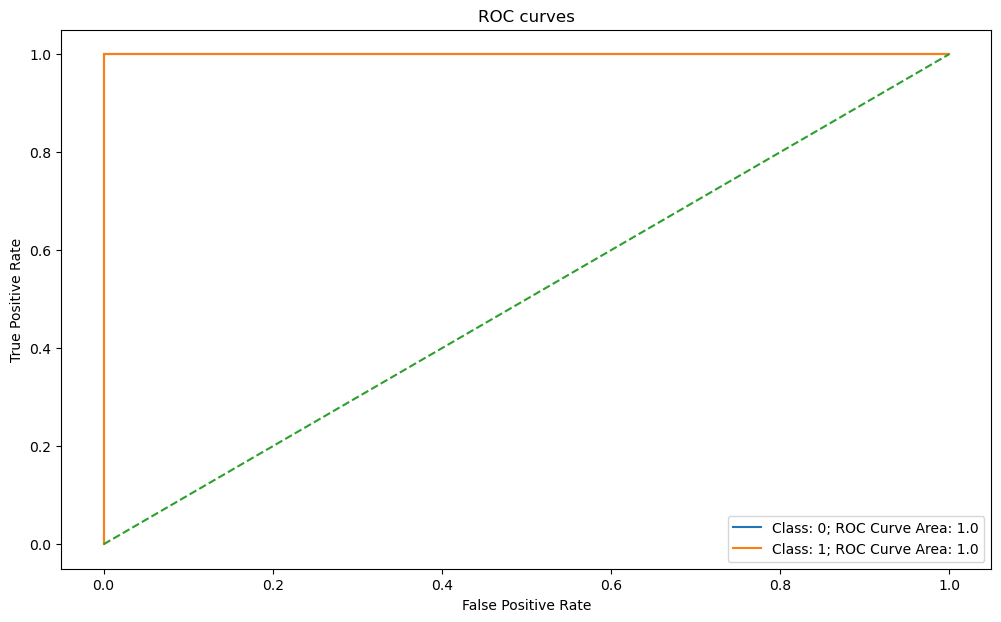

In [20]:
classification_and_roc_calculation(trainX, trainY, selected_features)

#### v. Test Classifier

In [22]:
test_set = process_data(selected_features, COLUMN_NAMES, test, segments=1)
test_set = convert_labels_to_boolean(pd.DataFrame(test_set))
testX, testY = get_X_Y(test_set)
testX

min1  1st_quartile1  3rd_quartile2  mean5  median5  3rd_quartile5
0   40.624792        42.0000           1.30  27.25  33.0000          38.25
1   42.812812        43.6700           1.22  27.67  32.0000          38.50
2   34.227771        37.7500          14.50   6.75  14.7500          26.00
3   33.509729        36.7500          13.05   7.25  14.6275          25.00
4   34.660583        38.2500          13.44   7.00  14.2500          24.50
5   24.562958        26.5000           6.87  10.67  20.5000          30.00
6   27.464604        30.0000           7.76   0.00  15.0000          33.00
7   44.334729        46.5000           3.90   0.00   9.3300          23.00
8   43.174938        44.5000           2.12   2.00  12.7500          21.25
9   42.760562        45.3725           3.34   1.33  13.0000          21.33
10  42.363563        43.5000           4.44   1.00  10.1875          28.00
11  45.917667        46.5000           4.87   2.00  16.5000          24.00
12  45.239667        45.3300           1.00   4.75  17.6275          26.75
13  27.716375        29.0000           1.79   0.00   5.5000          21.00
14  44.182937        48.0000           3.11   0.00   2.0000          12.75
15  48.004167        48.0000           0.43   0.00   4.6700          12.00
16  37.177042        40.2500           8.58   7.00  17.9500          25.50
17  37.561187        40.2500           9.91  10.50  18.0000          24.33
18  37.058708        40.0625          14.17   7.50  16.0000          24.25

[[15  0]
 [ 0  4]]


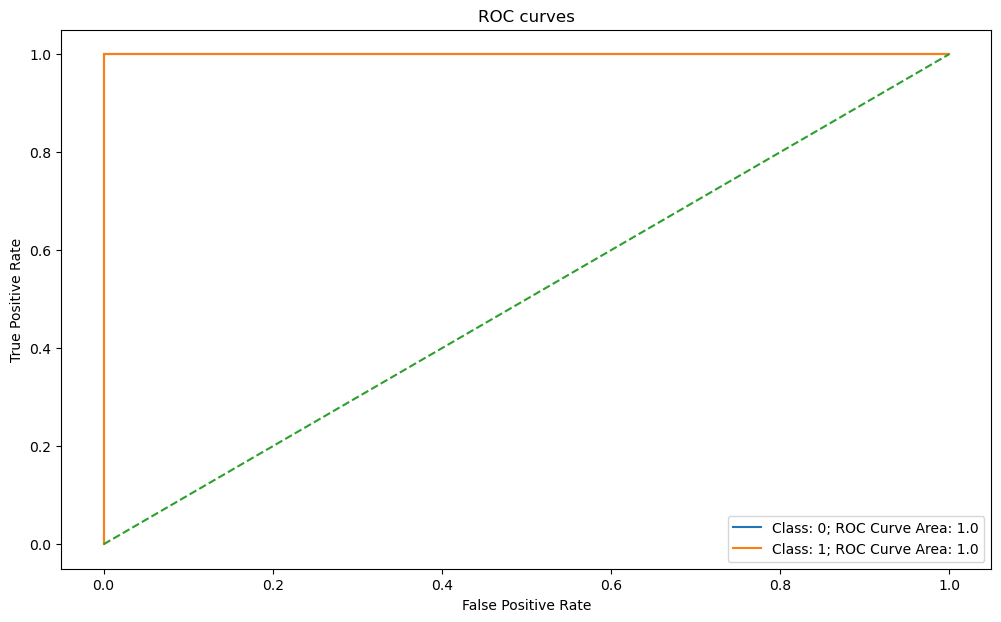

In [23]:
classification_and_roc_calculation(testX, testY, selected_features, isTest=True)

Observation:

The accuracy on the test set is the same as the cross-validation accuracy obtained previously.

#### vi. Separation

Observations:
    
Results indicate complete sepration. The inference can be made that the classes are well separated as complete separation is present.The Maximum Likelihood Estimator does not exist and the parameters are not identified in this case.


#### vii. Imbalance

Observations:
    Yes there is an indication of imbalanced classes.
    0 = non-bending classes and 1 = bending classes. According to the 
    confusion matrices, that there are 69 instances of non-bending classes and 9 instances for bending classes 
    which goes to show classes are imbalanced.

Since the answer to the above observation is yes, it means that we will have to build a regression model on 
case-controlled sampling i.e. we will have to oversample.

In [24]:
print("Performing logistic regression with oversampling=True")
cross_validation_factor = 5
L = 20
combination = {
    'pair(l, p)': [],
    'score': []
}
for l_val in range(1, L + 1):
    model, selector = logistic_regression(train, test, l_val, cross_validation_factor, oversample=True)
    nf = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    combination['pair(l, p)'].append((l_val, nf))
    combination['score'].append(round(score, 4))

df = pd.DataFrame(combination)
df

Performing logistic regression with oversampling=True
Running Logistic Regression for l-value 1
Performing oversampling of dataset...
Running Logistic Regression for l-value 2
Performing oversampling of dataset...
Running Logistic Regression for l-value 3
Performing oversampling of dataset...
Running Logistic Regression for l-value 4
Performing oversampling of dataset...
Running Logistic Regression for l-value 5
Performing oversampling of dataset...
Running Logistic Regression for l-value 6
Performing oversampling of dataset...
Running Logistic Regression for l-value 7
Performing oversampling of dataset...
Running Logistic Regression for l-value 8
Performing oversampling of dataset...
Running Logistic Regression for l-value 9
Performing oversampling of dataset...
Running Logistic Regression for l-value 10
Performing oversampling of dataset...
Running Logistic Regression for l-value 11
Performing oversampling of dataset...
Running Logistic Regression for l-value 12
Performing oversampli

pair(l, p)   score
0      (1, 4)  1.0000
1      (2, 7)  0.9833
2      (3, 3)  1.0000
3      (4, 3)  0.9917
4      (5, 3)  0.9917
5      (6, 3)  0.9917
6      (7, 2)  0.9917
7      (8, 3)  0.9917
8      (9, 9)  1.0000
9     (10, 6)  1.0000
10    (11, 2)  0.9917
11    (12, 4)  0.9917
12    (13, 4)  1.0000
13    (14, 7)  1.0000
14    (15, 9)  1.0000
15    (16, 8)  1.0000
16    (17, 4)  1.0000
17    (18, 3)  1.0000
18    (19, 6)  1.0000
19    (20, 7)  1.0000

In [26]:
l_value = 1
fold_count = 5
features = generate_features(ORDERED_STATS, 6 * l_value + 1)
classifier, selector = logistic_regression(train, test, l_value, fold_count, oversample=True)
selected_features = get_selected_features(features, selector)
selected_features

Running Logistic Regression for l-value 1
Performing oversampling of dataset...


['1st_quartile1', 'min5', 'mean5', '3rd_quartile5']

Performing oversampling of dataset...
[[60  0]
 [ 0 60]]


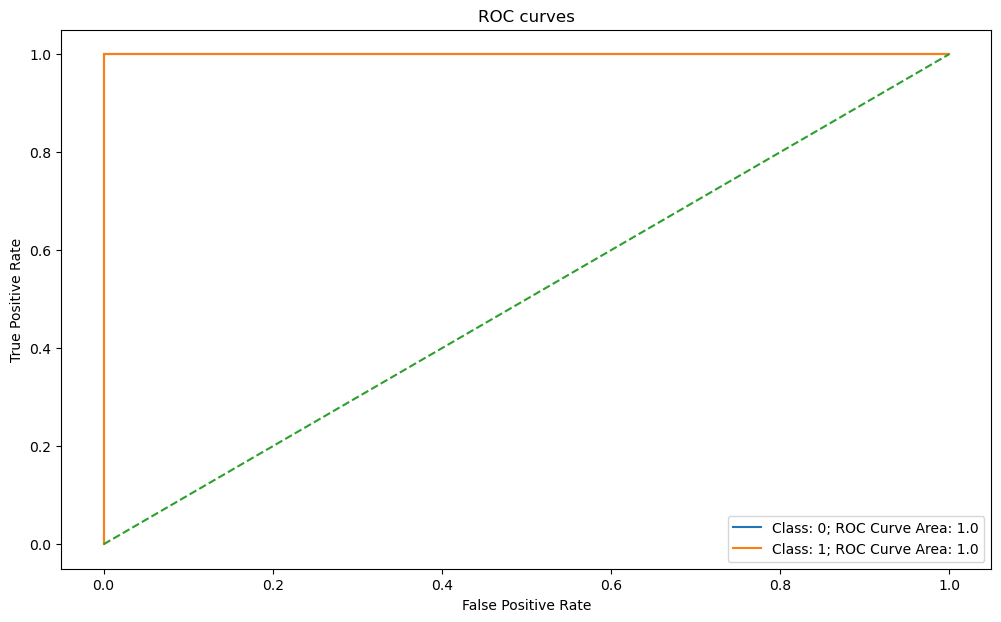

In [28]:
train_set = process_data(selected_features, COLUMN_NAMES, train, segments=1)
train_set = convert_labels_to_boolean(pd.DataFrame(train_set))
train_set = oversample_dataset(train_set)
trainX, trainY = get_X_Y(train_set)
classification_and_roc_calculation(trainX, trainY, selected_features)

[[15  0]
 [ 0  4]]


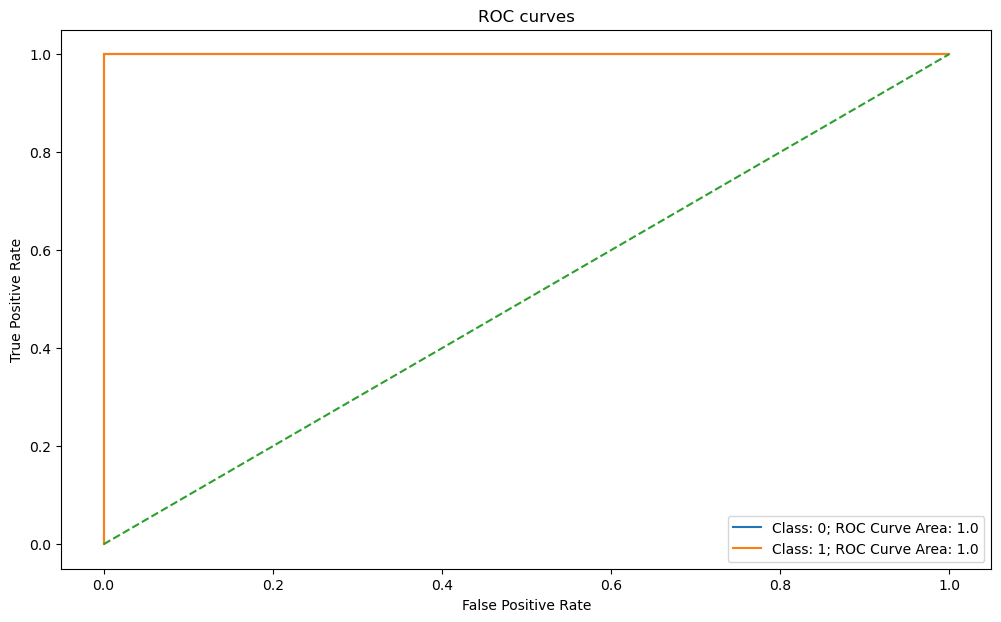

In [29]:
test_set = process_data(selected_features, COLUMN_NAMES, test, segments=1)
test_set = convert_labels_to_boolean(pd.DataFrame(test_set))
# test_set = oversample_dataset(test_set)
testX, testY = get_X_Y(test_set)
classification_and_roc_calculation(testX, testY, selected_features)

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [30]:
max_test_accuracy = 0
optimal_L = 1

def perform_regression_with_classifier(classifier, classifier_name, l_val, kwargs, penalty='none', 
                              is_binary_classification=True, draw_roc=False):
    print(f'Running {classifier_name} for l-value {l_val}')
    features = generate_features(ORDERED_STATS, 6 * l_val + 1)
    train_set = process_data(features, COLUMN_NAMES, train, segments=l_val)
    test_set = process_data(features, COLUMN_NAMES, test, segments=l_val)
    
    if is_binary_classification:
        train_set = binary_classify(pd.DataFrame(train_set))
        test_set = binary_classify(pd.DataFrame(test_set))
        
    trainX, trainY = get_X_Y(train_set)
    testX, testY = get_X_Y(test_set)
    
    if is_binary_classification:
        trainY = trainY.astype('int')
        testY = testY.astype('int')
    
    classifier2 = classifier(**kwargs)
    classifier2.fit(trainX, trainY)
    
    if not draw_roc:    
        train_score = round(classifier2.score(trainX, trainY), 4)
        test_score = round(classifier2.score(testX, testY), 4)
        print(f'Value of L: {l_val} | train_score: {train_score} | test_score: {test_score}')
        print(f'Value of L: {l_val} | train_error: {round((1 - train_score), 4)} | test_error: {round((1 - test_score), 4)}\n')
        global max_test_accuracy
        global optimal_L
        if test_score > max_test_accuracy:
            max_test_accuracy = test_score
            optimal_L = l_val
        
        if l_val == 20:
            print('\n')
            print(f'The maximum accuracy is {max_test_accuracy} (for L-value: {optimal_L})')
            print(f'Further calculations will be done with L-value: {optimal_L}')
        
    else:
        train_predictY_prob = classifier2.predict_proba(trainX)
        test_predictY_prob = classifier2.predict_proba(testX)

        predictY = classifier2.predict(testX)
        cm = confusion_matrix(testY, predictY)
        print(f"Confusion matrix for test data:\n{cm}")
        
        print("ROC Curve for Train Data")
        plot_roc_curve(trainY, train_predictY_prob, classifier2)
        
        print("ROC Curve for Test Data")
        plot_roc_curve(testY, test_predictY_prob, classifier2)


In [31]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'scoring' : 'accuracy',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'liblinear'
}

fold_count = 5

for l_val in range(1, 21):
    perform_regression_with_classifier(LogisticRegressionCV,
                                       "Logistic Regression", 
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=True, 
                                       draw_roc=False)


Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 1.0
Value of L: 1 | train_error: 0.0 | test_error: 0.0

Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 0.9565 | test_score: 0.9474
Value of L: 2 | train_error: 0.0435 | test_error: 0.0526

Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 1.0
Value of L: 3 | train_error: 0.0 | test_error: 0.0

Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.9474
Value of L: 4 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.9474
Value of L: 5 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.9474
Value of L: 6 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test_score: 1.0
Value o

Running Logistic Regression for l-value 1
Confusion matrix for test data:
[[15  0]
 [ 0  4]]
ROC Curve for Train Data


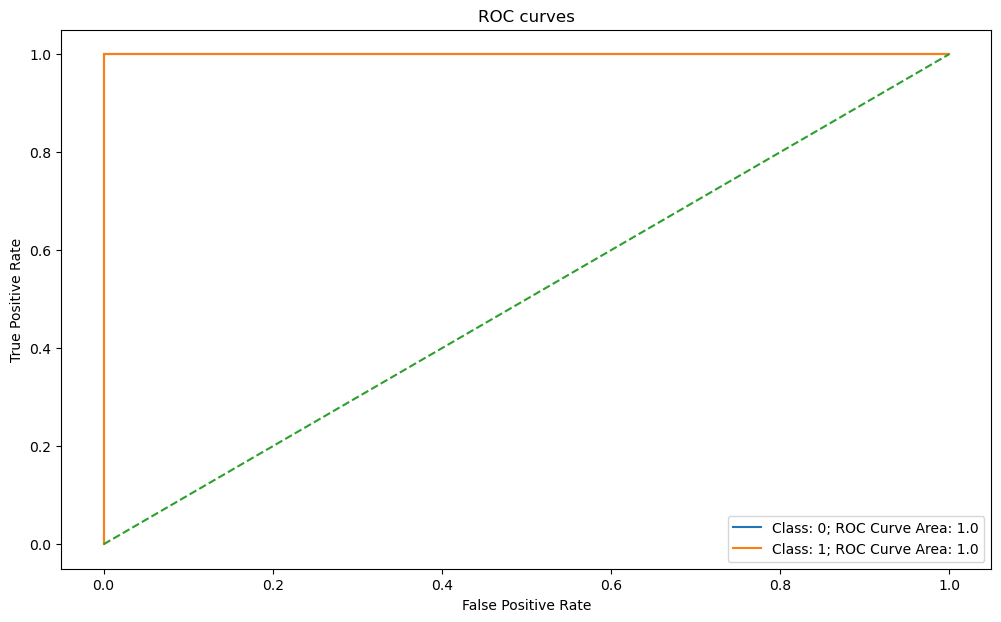

ROC Curve for Test Data


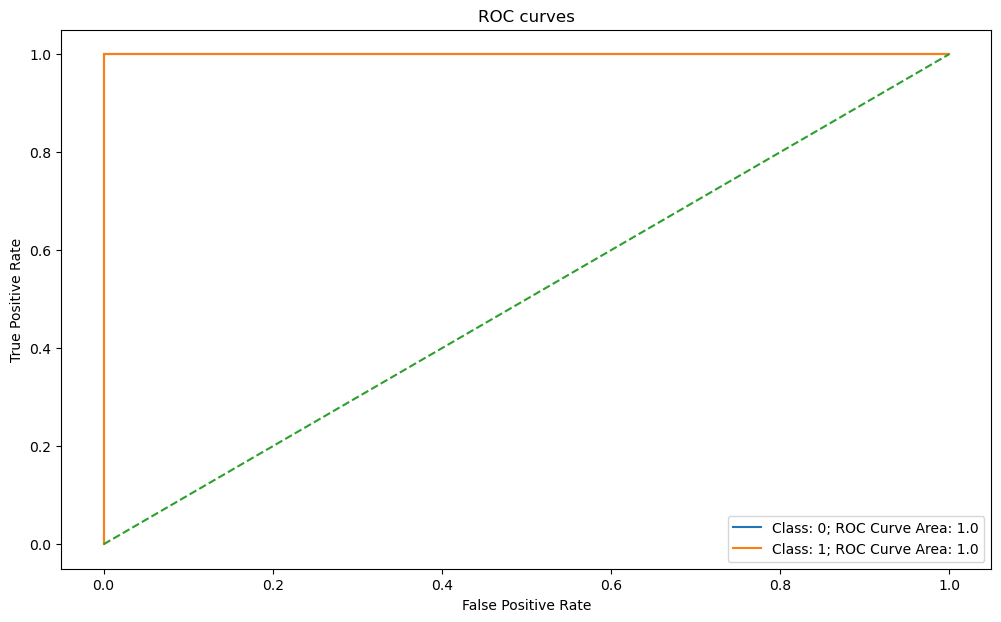

In [32]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'solver' : 'liblinear'
}

fold_count = 5
best_l = 1

perform_regression_with_classifier(LogisticRegression,
                                   "Logistic Regression",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=True, 
                                   draw_roc=True)

#### ii. Comparison

Observations:
    
    The L1-penalized logistic regression has better performance in terms of accuracy when tested on the test data 
    (approximately ~ 1.0) and hence, the L1-penalized performs better. THe L1-regularization is easier to implement 
    as feature selection does not need to be manual.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [33]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'multi_class': 'multinomial',
    'cv': 5,
    'random_state' : 69,
    'solver' : 'saga'
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

for l_val in range(1, 21):
    perform_regression_with_classifier(LogisticRegressionCV, 
                                       "Logistic Regression",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)

Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.9474
Value of L: 2 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 0.8421
Value of L: 3 | train_error: 0.0 | test_error: 0.1579

Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.8947
Value of L: 4 | train_error: 0.0 | test_error: 0.1053

Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.8421
Value of L: 5 | train_error: 0.0 | test_error: 0.1579

Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.7895
Value of L: 6 | train_error: 0.0 | test_error: 0.2105

Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test_score: 0.736

Running Logistic Regression for l-value 2
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


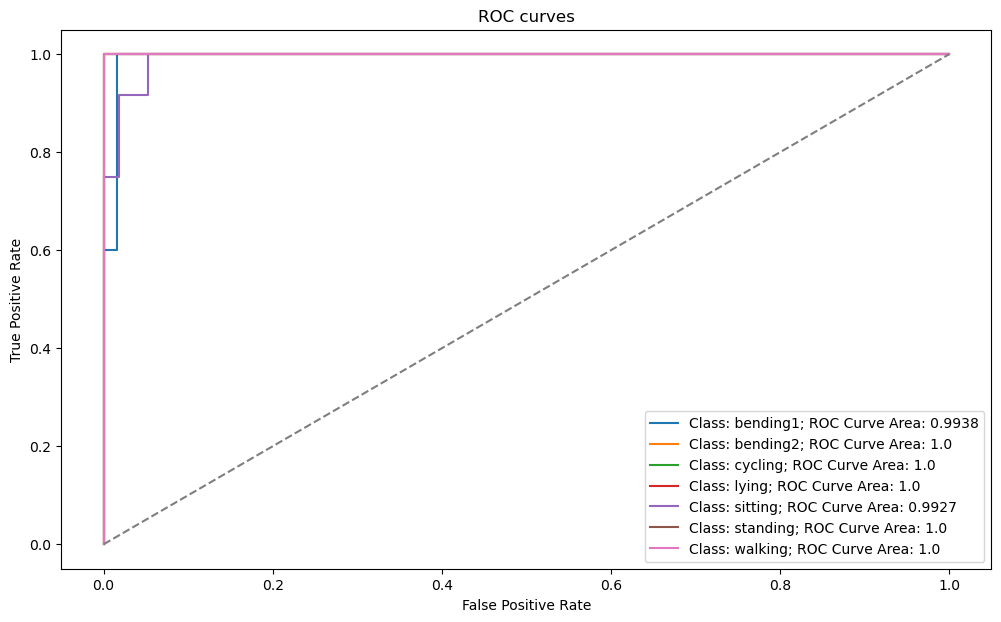

ROC Curve for Test Data


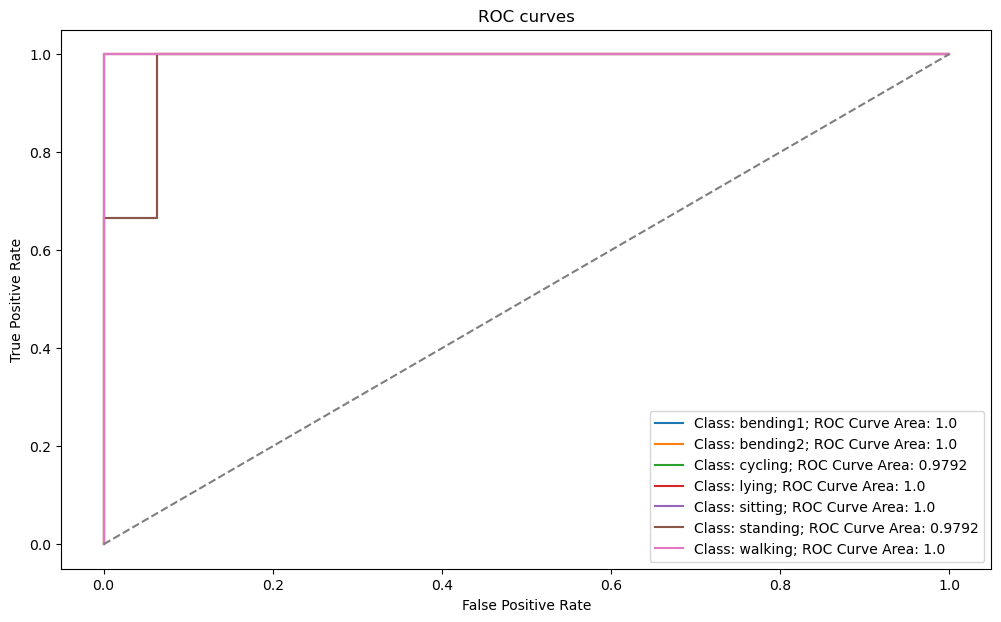

In [34]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'multi_class' : 'multinomial',
    'solver' : 'saga'
}

fold_count = 5
best_l = optimal_L

perform_regression_with_classifier(LogisticRegression, 
                                   "Logistic Regression",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

#### ii. Naive Bayes

In [35]:
kwargs = {
    
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

for l_val in range(1, 21):
    perform_regression_with_classifier(GaussianNB, 
                                       "Naive Bayes Classifier with Gaussian Prior",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)


Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

Running Naive Bayes Classifier with Gaussian Prior for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.6316
Value of L: 2 | train_error: 0.0 | test_error: 0.3684

Running Naive Bayes Classifier with Gaussian Prior for l-value 3
Value of L: 3 | train_score: 0.9855 | test_score: 0.7368
Value of L: 3 | train_error: 0.0145 | test_error: 0.2632

Running Naive Bayes Classifier with Gaussian Prior for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.7895
Value of L: 4 | train_error: 0.0 | test_error: 0.2105

Running Naive Bayes Classifier with Gaussian Prior for l-value 5
Value of L: 5 | train_score: 0.9855 | test_score: 0.7895
Value of L: 5 | train_error: 0.0145 | test_error: 0.2105

Running Naive Bayes Classifier with Gaussian Prior for l-value 6
Value of L: 6 | train_score: 0.971 | test_score: 0.63

Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


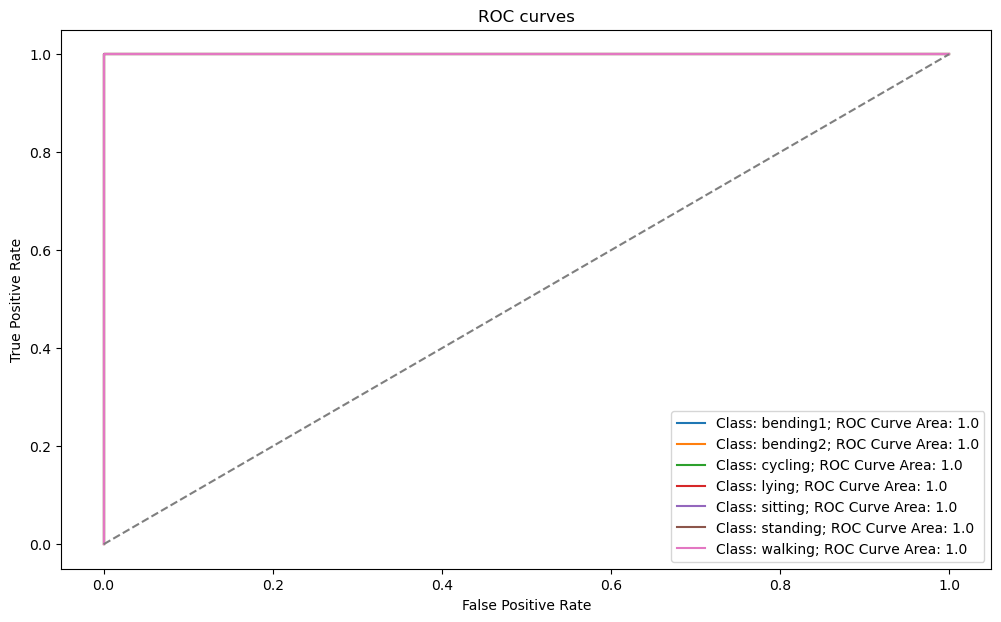

ROC Curve for Test Data


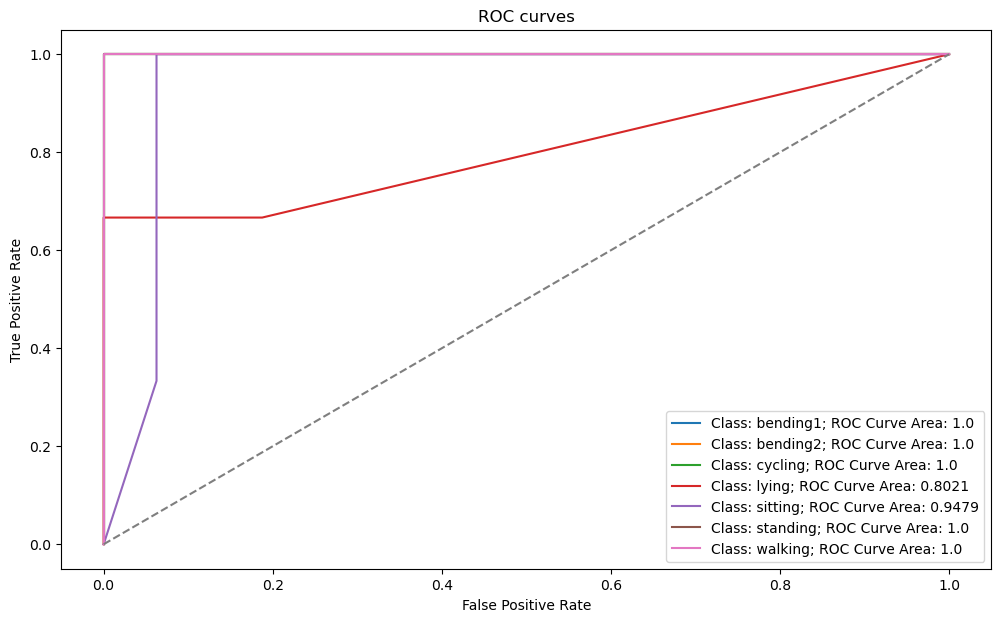

In [36]:
kwargs = {
    
}

fold_count = 5
best_l = optimal_L

perform_regression_with_classifier(GaussianNB, 
                                   "Naive Bayes Classifier with Gaussian Prior",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)


In [37]:
kwargs = {
    
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

for l_val in range(1, 21):
    perform_regression_with_classifier(MultinomialNB, 
                                       "Naive Bayes Classifier with Multinomial Prior",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)

Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Value of L: 1 | train_score: 0.9275 | test_score: 0.8947
Value of L: 1 | train_error: 0.0725 | test_error: 0.1053

Running Naive Bayes Classifier with Multinomial Prior for l-value 2
Value of L: 2 | train_score: 0.8841 | test_score: 0.7368
Value of L: 2 | train_error: 0.1159 | test_error: 0.2632

Running Naive Bayes Classifier with Multinomial Prior for l-value 3
Value of L: 3 | train_score: 0.8986 | test_score: 0.7895
Value of L: 3 | train_error: 0.1014 | test_error: 0.2105

Running Naive Bayes Classifier with Multinomial Prior for l-value 4
Value of L: 4 | train_score: 0.913 | test_score: 0.7895
Value of L: 4 | train_error: 0.087 | test_error: 0.2105

Running Naive Bayes Classifier with Multinomial Prior for l-value 5
Value of L: 5 | train_score: 0.9275 | test_score: 0.7368
Value of L: 5 | train_error: 0.0725 | test_error: 0.2632

Running Naive Bayes Classifier with Multinomial Prior for l-value 6
Value of L: 6 | tra

Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


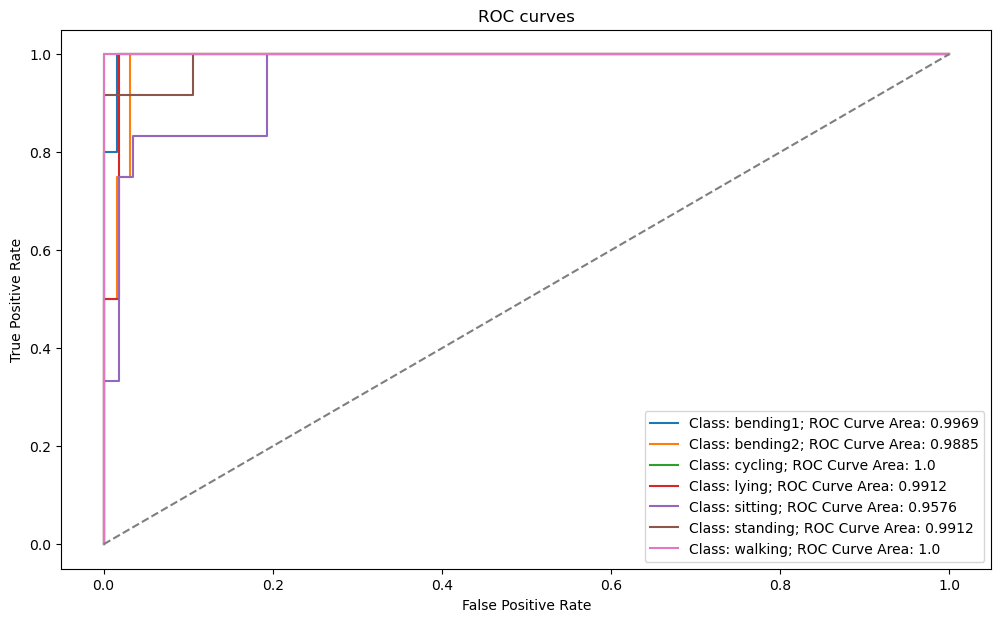

ROC Curve for Test Data


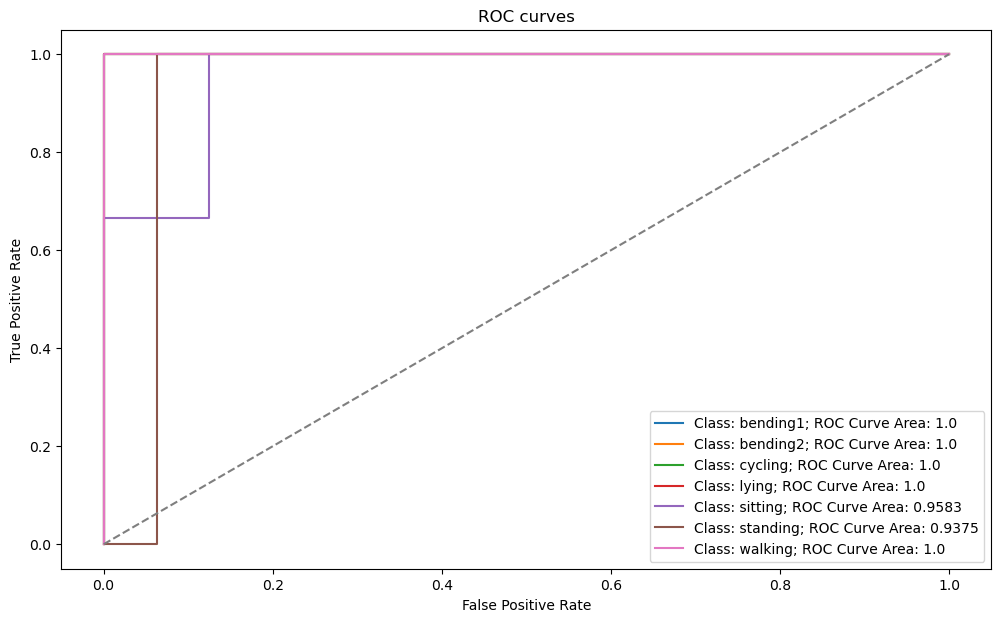

In [38]:
kwargs = {
    
}

fold_count = 5
best_l = optimal_L

perform_regression_with_classifier(MultinomialNB, 
                                   "Naive Bayes Classifier with Multinomial Prior",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

#### 2c-iii) Which method is better for multi-class classification in this problem?



Observations:
    
    The area under the ROC curve (AUC) is relatively better for the Logistic Regression curve than any other 
    classifer prior (Gaussian or Multinomial) and hence, I would say that Logistic Regression has better 
    classification for the given dataset

## 3. ISLR 4.8.3

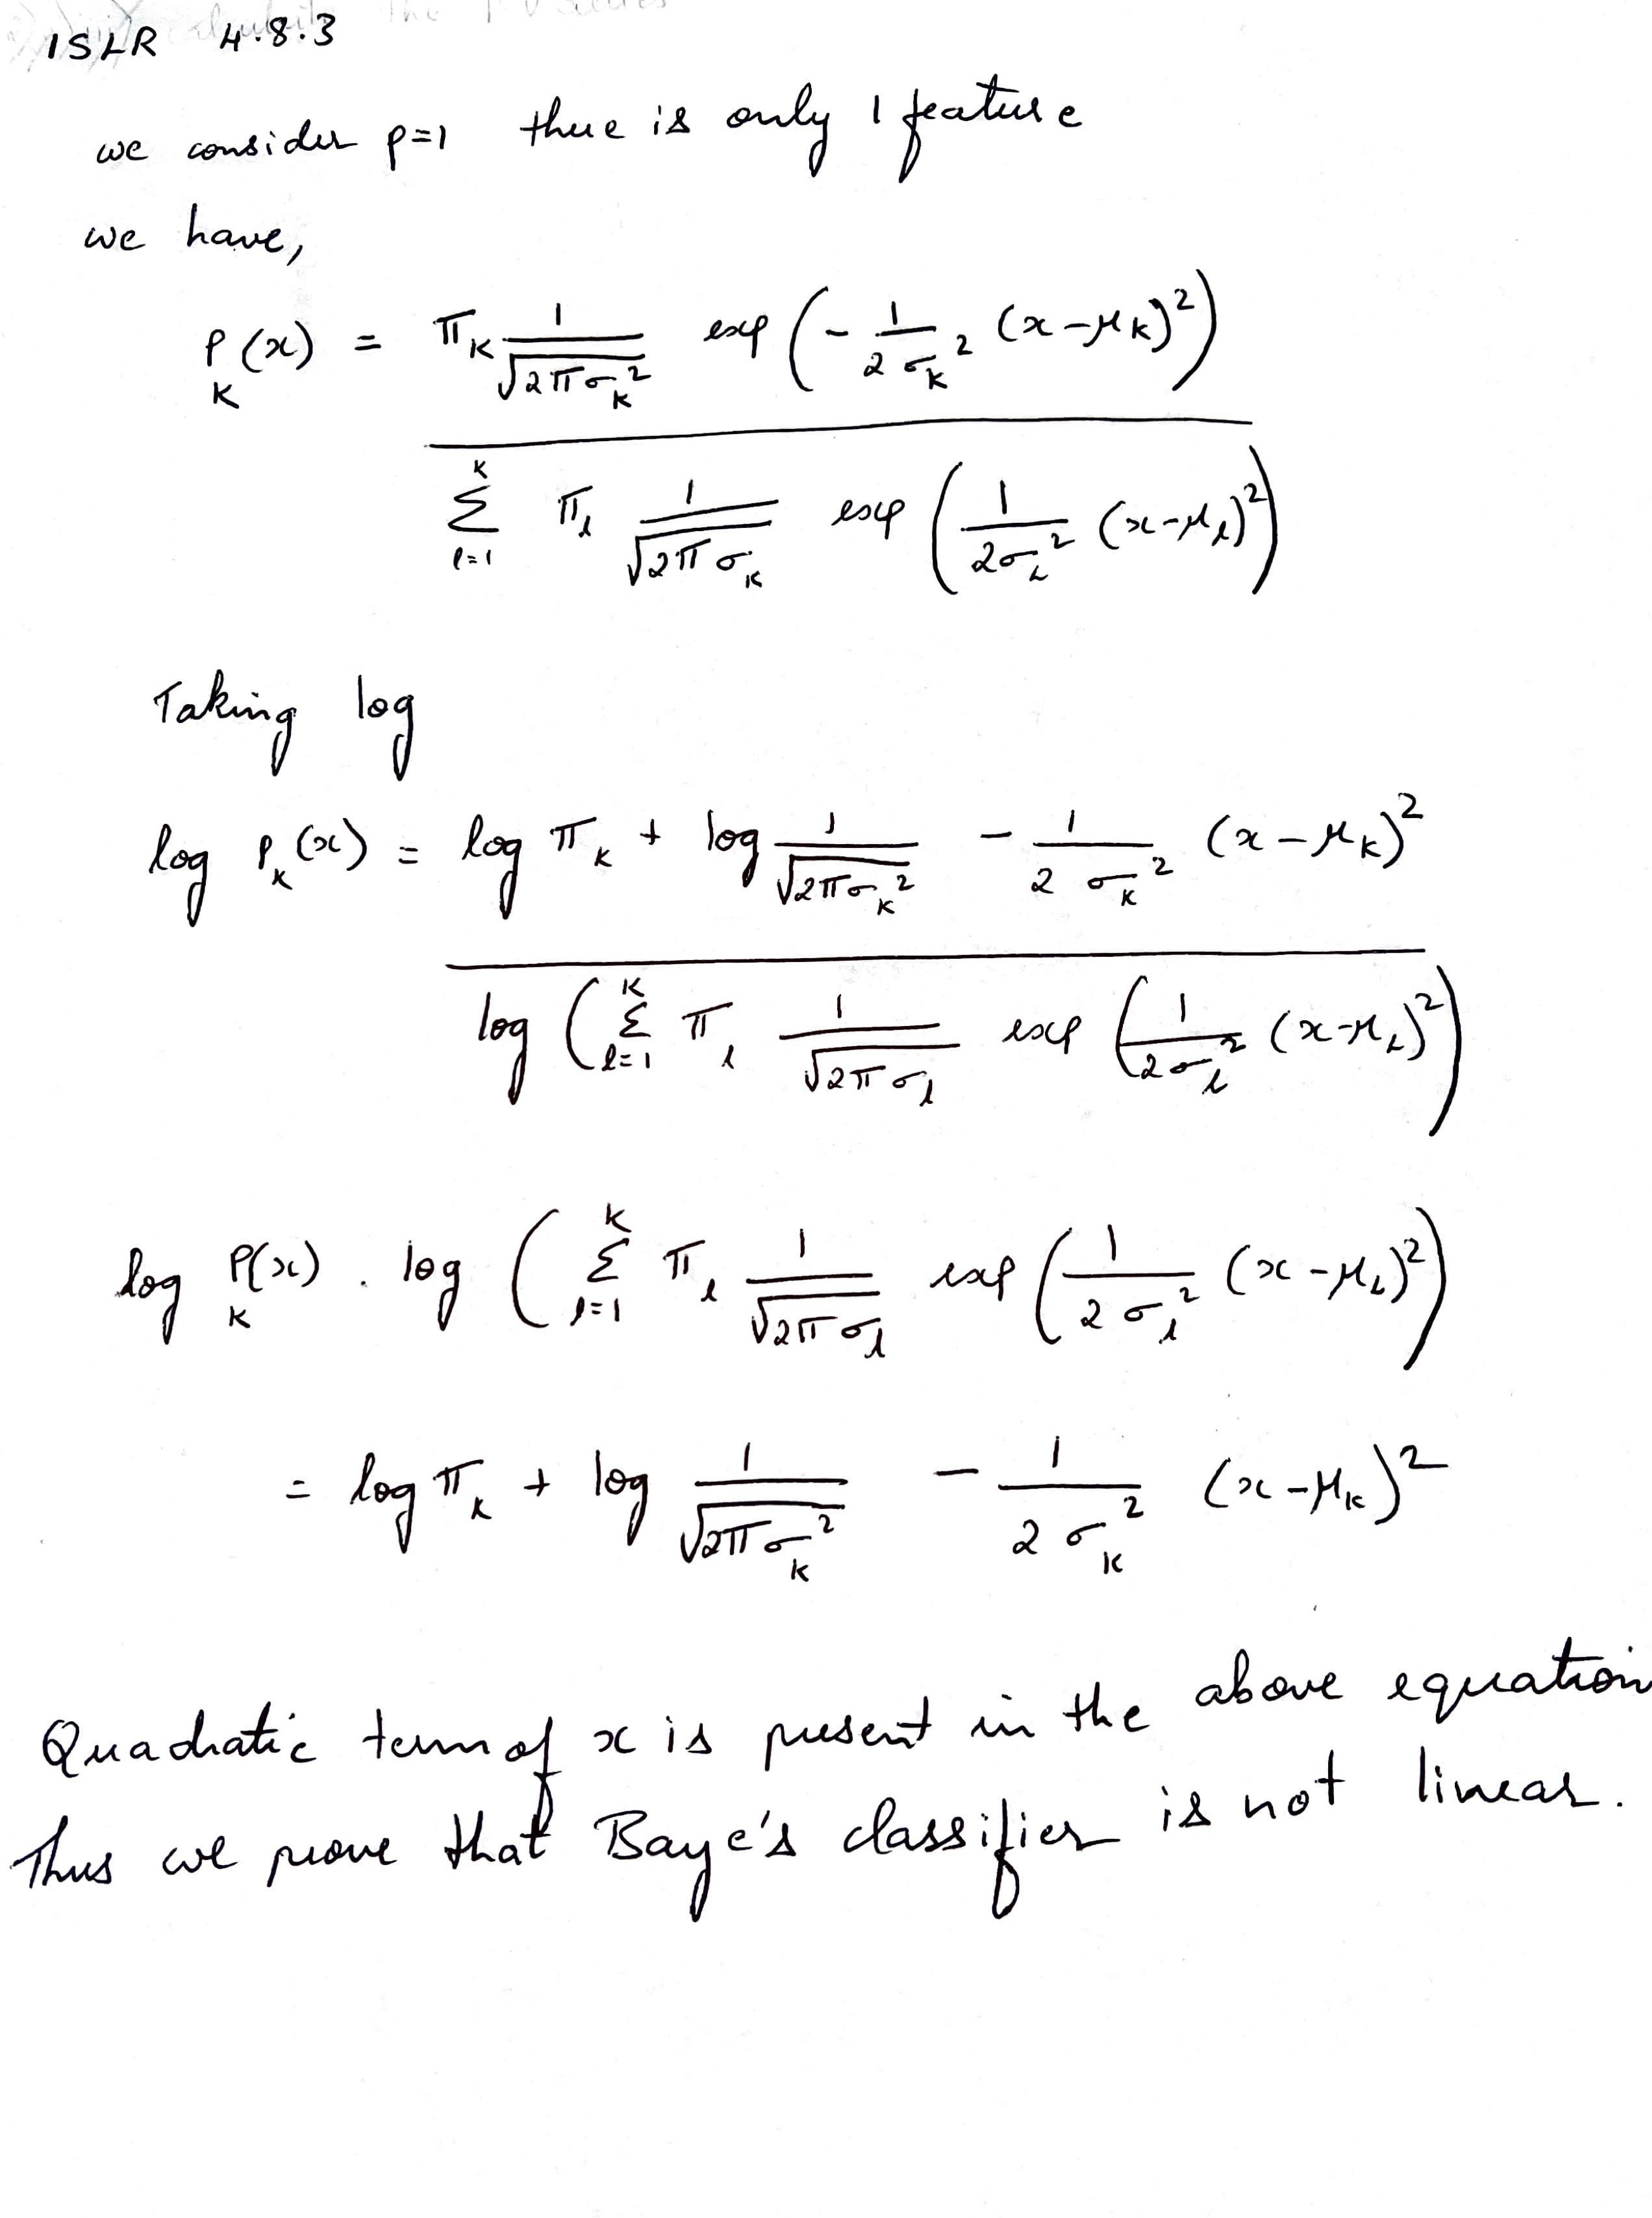

## 4. ISLR 4.8.7

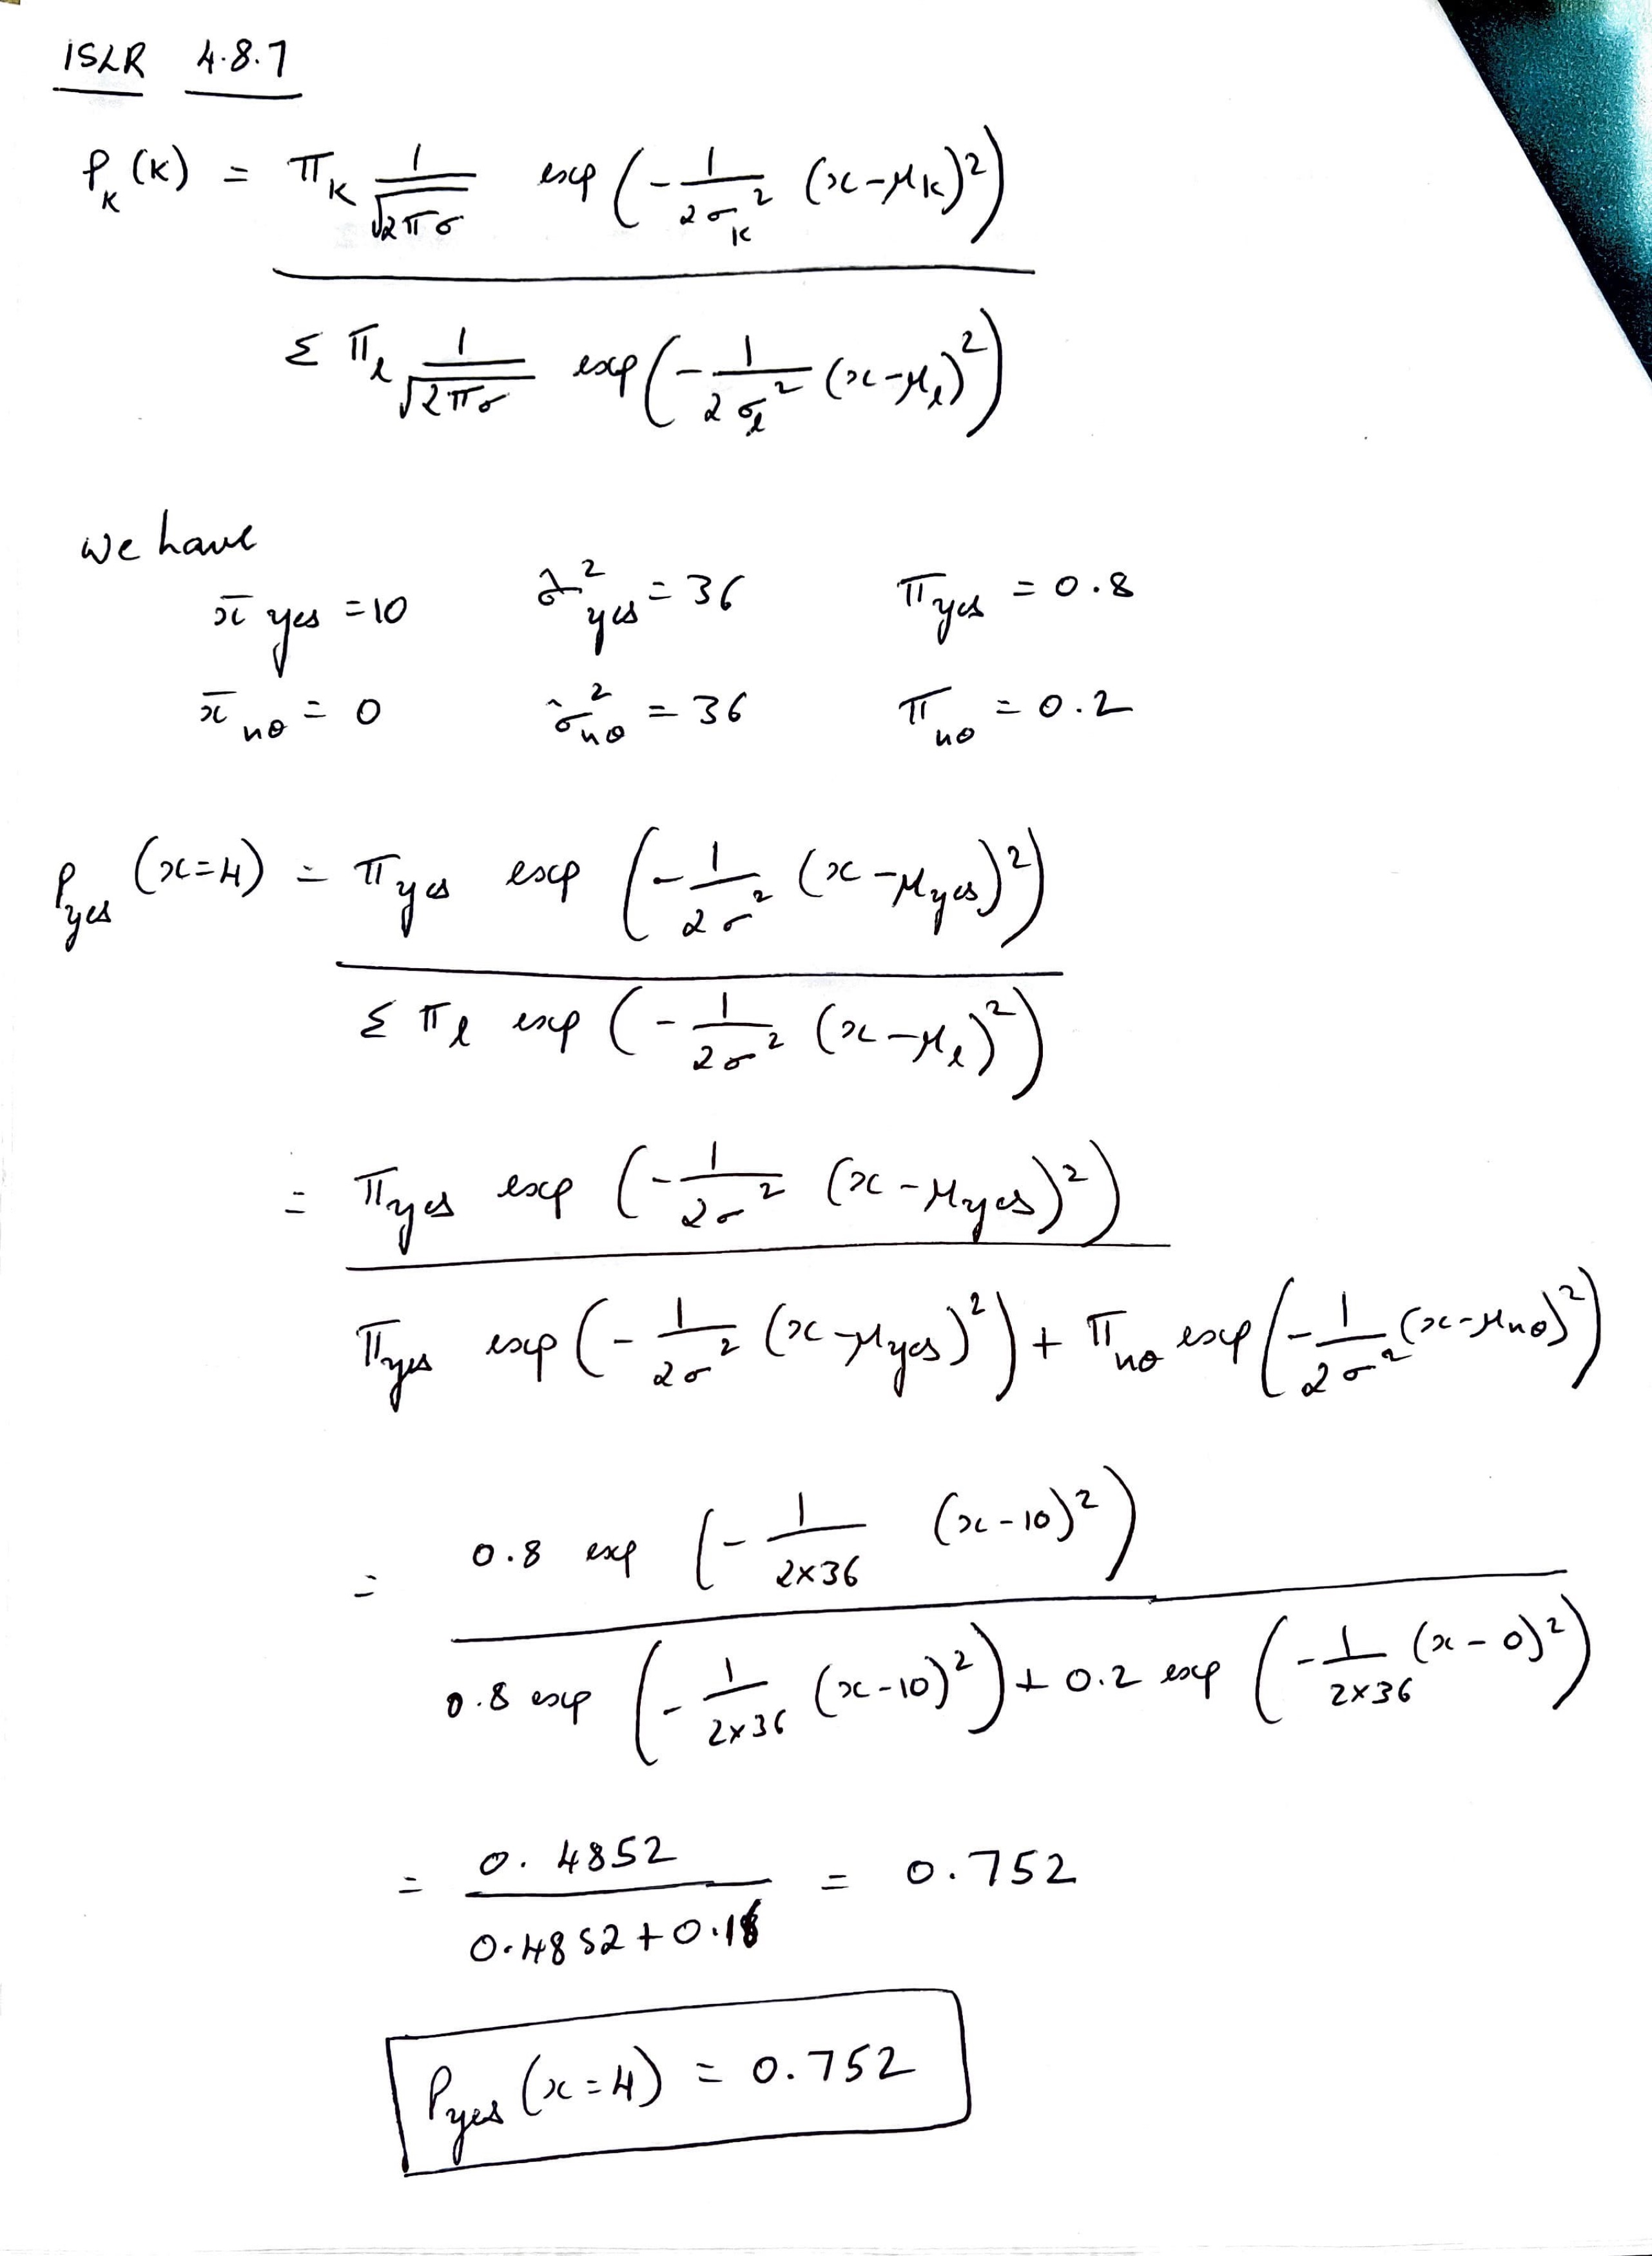